In [29]:
#neural network imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

#vision imports
from torchvision import transforms, datasets

#general library imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [30]:
#GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#turn images into tensors and 256x256 images
transform = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.ToTensor()
    ])

#move to ImageFolder
dataset = datasets.ImageFolder(root="data", transform=transform)

#split data into train, validation, and test
train_size = int(0.7 * len(dataset))  
val_size = int(0.2 * len(dataset)) 
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#insert data into dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device: cuda


In [34]:
#define binary classification CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__() #initialize nn.module
        self.pool = nn.MaxPool2d(2,2)
        
        self.relu = nn.ReLU()

        #in: 256x256x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        #out: 32x32x64

        self.fc1 = nn.Linear(in_features=(8*8*256), out_features=64)
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv3(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv4(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv5(output)
        output = self.relu(output)
        output = self.pool(output)
        
        output = output.view(-1, 8*8*256) #flatten batch_size, channel*height*width to batch_size, input features
        output = self.fc1(output)
        output = self.drop(output)
        output = self.fc2(output)
        return output


    def train_model(self, optimizer, criterion, train_loader, val_loader, num_epochs, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc):
        best_val_loss = float("inf")
        best_epoch = 0

        for epoch in range(num_epochs):
            batch_train_loss = []
            batch_train_acc = []
            batch_val_loss = []
            batch_val_acc = []

            self.train() #Set to training mode for batchnorm.
            for (data,label) in train_loader:
                data, label = data.to(device), label.to(device) #move data to GPU with model

                optimizer.zero_grad()
                prediction = self.forward(data)

                #batch loss
                loss = criterion(prediction, label)
                batch_train_loss.append(loss.item())

                loss.backward()
                optimizer.step()

                #batch accuracy
                _, prediction_labels = torch.max(prediction, dim=1)
                actual_labels = label.cpu().numpy()
                prediction_labels = prediction_labels.cpu().numpy()

                train_acc = accuracy_score(actual_labels, prediction_labels)
                batch_train_acc.append(train_acc)
                
            #epoch accuracy
            avg_train_acc = sum(batch_train_acc)/len(batch_train_acc)
            epoch_train_acc.append(avg_train_acc)

            #epoch loss
            avg_train_loss = sum(batch_train_loss)/len(batch_train_loss)
            epoch_train_loss.append(avg_train_loss)  

            self.eval() 
            with torch.no_grad():
                for (data,label) in val_loader:
                    data, label = data.to(device), label.to(device)

                    prediction = self.forward(data)
                    
                    #batch loss
                    loss = criterion(prediction, label)
                    batch_val_loss.append(loss.item())

                    #batch accuracy
                    _, prediction_labels = torch.max(prediction, dim=1)
                    actual_labels = label.cpu().numpy()
                    prediction_labels = prediction_labels.cpu().numpy()

                    val_acc = accuracy_score(actual_labels, prediction_labels)
                    batch_val_acc.append(val_acc)

                #epoch accuracy
                avg_val_acc = sum(batch_val_acc)/len(batch_val_acc)
                epoch_val_acc.append(avg_val_acc)

                #epoch loss
                avg_val_loss = sum(batch_val_loss)/len(batch_val_loss)
                epoch_val_loss.append(avg_val_loss)

            #update best epoch
            if(avg_val_loss < best_val_loss):
                torch.save(self.state_dict(), "model-weights/best_classifier.pth")
                best_val_loss = avg_val_loss
                best_epoch = epoch+1

            print(f"Epoch: {epoch+1} train acc: {avg_train_acc:.4f} train loss: {avg_train_loss:.4f} val acc: {avg_val_acc:.4f} val loss: {avg_val_loss:.4f}")
            if(epoch == num_epochs-1):
                print(f"Best val loss: {best_val_loss:.4f} Best epoch: {best_epoch}")


In [35]:
#Set hyperparameters
model = Network().to(device) #set to GPU if available

num_epochs = 15
input_features = 256*256*3
output_features = 2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

epoch_train_loss = []
epoch_val_loss = []
epoch_train_acc = []
epoch_val_acc = []

model.train_model(optimizer, criterion, train_loader, val_loader, num_epochs, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc)

Epoch: 1 train acc: 0.5862 train loss: 0.6561 val acc: 0.4844 val loss: 0.6931
Epoch: 2 train acc: 0.7237 train loss: 0.5866 val acc: 0.7109 val loss: 0.5400
Epoch: 3 train acc: 0.7416 train loss: 0.5317 val acc: 0.8164 val loss: 0.4675
Epoch: 4 train acc: 0.7646 train loss: 0.4843 val acc: 0.8047 val loss: 0.5271
Epoch: 5 train acc: 0.7946 train loss: 0.4756 val acc: 0.8086 val loss: 0.4356
Epoch: 6 train acc: 0.8046 train loss: 0.4472 val acc: 0.8438 val loss: 0.3986
Epoch: 7 train acc: 0.8338 train loss: 0.4017 val acc: 0.8516 val loss: 0.3898
Epoch: 8 train acc: 0.8271 train loss: 0.3930 val acc: 0.8281 val loss: 0.3886
Epoch: 9 train acc: 0.8611 train loss: 0.3318 val acc: 0.8008 val loss: 0.3701
Epoch: 10 train acc: 0.8520 train loss: 0.3210 val acc: 0.8281 val loss: 0.3140
Epoch: 11 train acc: 0.9088 train loss: 0.2482 val acc: 0.8945 val loss: 0.2591
Epoch: 12 train acc: 0.9068 train loss: 0.2244 val acc: 0.8906 val loss: 0.2561
Epoch: 13 train acc: 0.9107 train loss: 0.2084 va

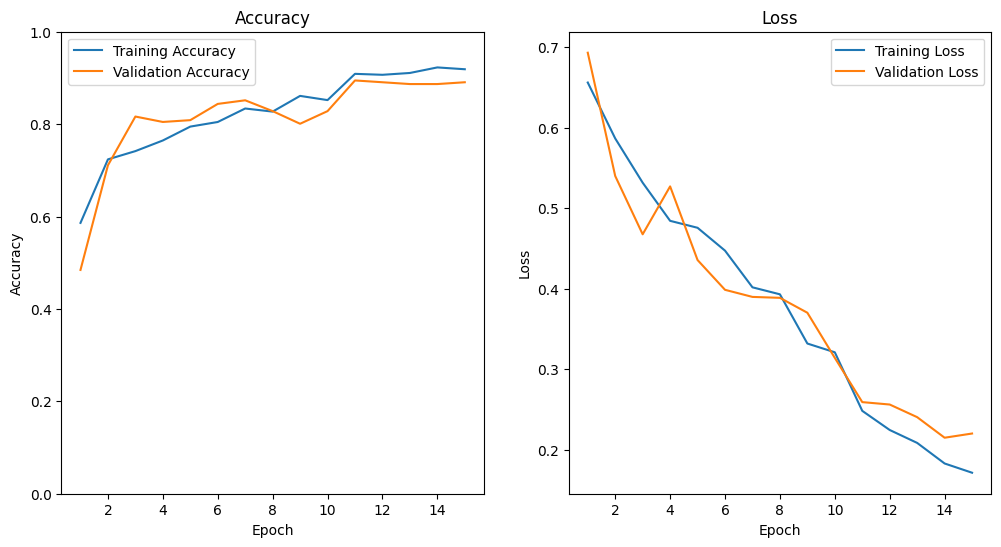

In [36]:
plt.figure(figsize=(12, 6))
#accuracy
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

epochs = range(1,num_epochs+1)
plt.plot(epochs, epoch_train_acc, label="Training Accuracy")
plt.plot(epochs, epoch_val_acc, label="Validation Accuracy")
plt.legend()

#loss
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(epochs, epoch_train_loss, label="Training Loss")
plt.plot(epochs, epoch_val_loss, label="Validation Loss")
plt.legend()
plt.show()


In [41]:
#test model
model.load_state_dict(torch.load("model-weights/best_classifier.pth", weights_only=True))

batch_test_loss = []
batch_test_acc = []

model.eval()
with torch.no_grad():

    for (data,label) in test_loader:
        data, label = data.to(device), label.to(device)

        prediction = model.forward(data)
        loss = criterion(prediction, label)

        #batch loss and accuracy
        batch_test_loss.append(loss.item())

        _, prediction_labels = torch.max(prediction, dim=1)
        actual_labels = label.cpu().numpy()
        prediction_labels = prediction_labels.cpu().numpy()
        batch_test_acc.append(accuracy_score(actual_labels, prediction_labels))

    #average test loss and accuracy
    avg_test_loss = sum(batch_test_loss)/len(batch_test_loss)
    avg_test_accuracy = sum(batch_test_acc)/len(batch_test_acc)

print(f"test accuracy: {avg_test_accuracy:.4f} test loss: {avg_test_loss:.4f}")


test accuracy: 0.8871 test loss: 0.3070
